# MPA Analysis# 

This notebook starts the analysis on the MPA data. We are analyzing the first measurement ('m1') done in September 2016. We have data at 3 biases: 400mV, 500mV, and 600mV. Based on the bias analysis, I expect that the best data will be at 600mV, but we should check this.

Note that the AC voltage applied is $V_{RMS} = 100$. mV

In [1]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [7]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False

os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\MPA\09_2016_m1\dev2\data_set\copy2')

# os.listdir()
tmax = 16
T = np.linspace(150,150+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 0


nPoints = 100
master0mv = np.zeros((tmax,nPoints,5))


z0 = np.zeros((tmax,nPoints,4))


# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master0mv[t,:,0] = tmp1[2:,0]
    master0mv[t,:,1] = savitzky_golay(tmp1[2:,1],51,5)
    master0mv[t,:,2] = savitzky_golay(tmp1[2:,2],51,5)
    master0mv[t,:,3] = savitzky_golay(tmp1[2:,3],51,5)
    master0mv[t,:,4] = savitzky_golay(tmp1[2:,4],51,5)

    z0[t,:,0] = ((master0mv[t,:,4]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    z0[t,:,1] = ((-master0mv[t,:,2]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    z0[t,:,2] = np.sqrt((z0[t,:,0]**2) + (z0[t,:,1]**2))
    z0[t,:,3] = -np.arctan(z0[t,:,1]/z0[t,:,0])*(180/np.pi)
                           
    


# define some simple functions to make the analysis code a bit more concise
def Zr(T):
    return z0[T,:,0]

def Zi(T):
    return z0[T,:,1]

def Zmag(T):
    return z0[T,:,2]

def phi(T):
    return z0[T,:,3]

def w(T):
    return master0mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\MPA\impedanceSpec\0mV'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 0


# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst = np.zeros(tmax)

for t in range (0,tmax): 
    RsEst[t] = Zr(t)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def Zmagadj(T):
    return np.sqrt(((z0[T,:,0]-RsEst[T])**2) + (z0[T,:,1]**2))

def phiadj(T):
    return -np.arctan(z0[T,:,1]/(z0[T,:,0]-RsEst[T]))*(180/np.pi)

Take a quick look at the 400 mV data, to identify salient features. Note that we are also plotting  the $R_{s}$ correted data.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


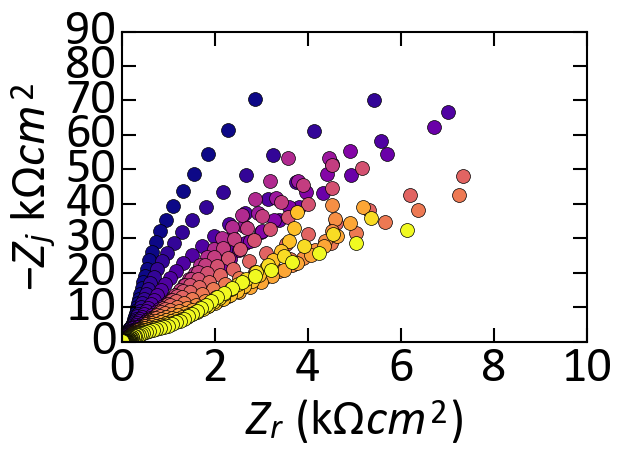

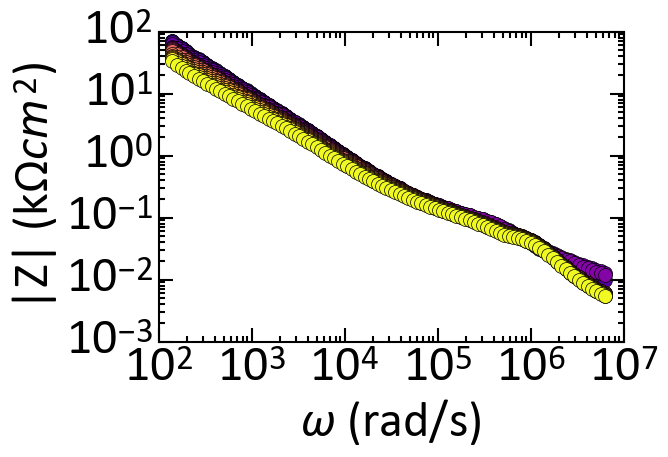

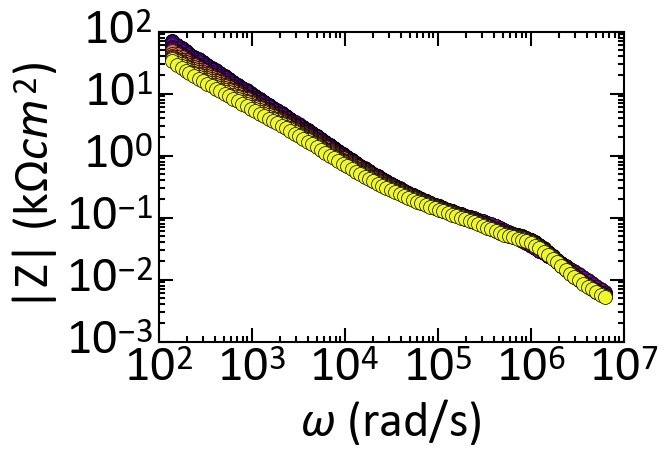

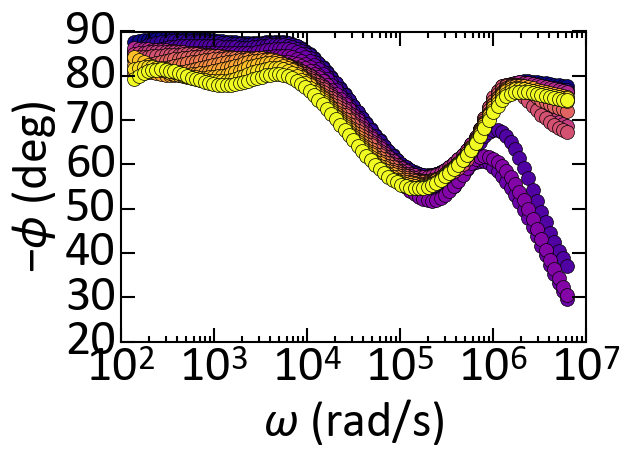

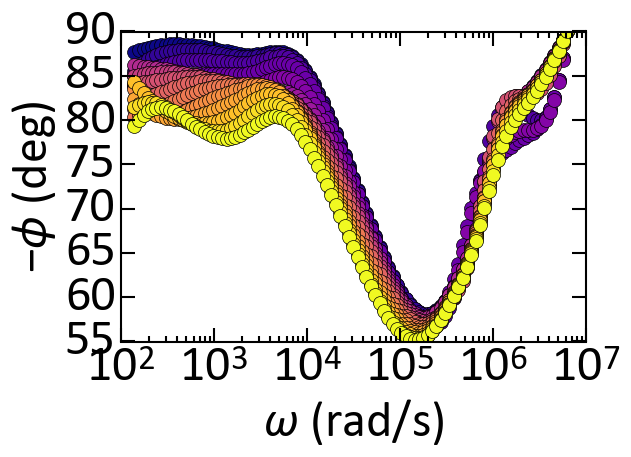

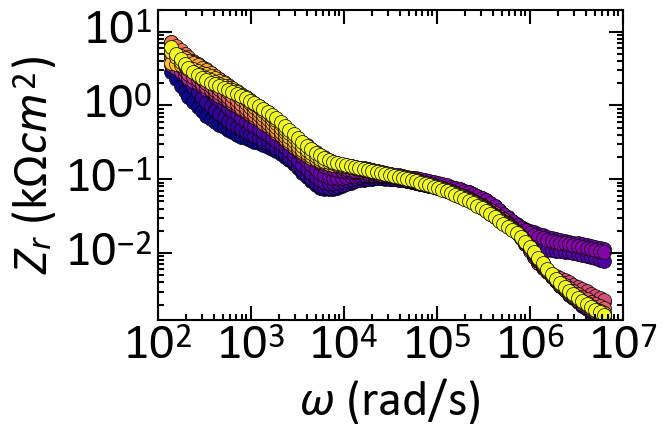

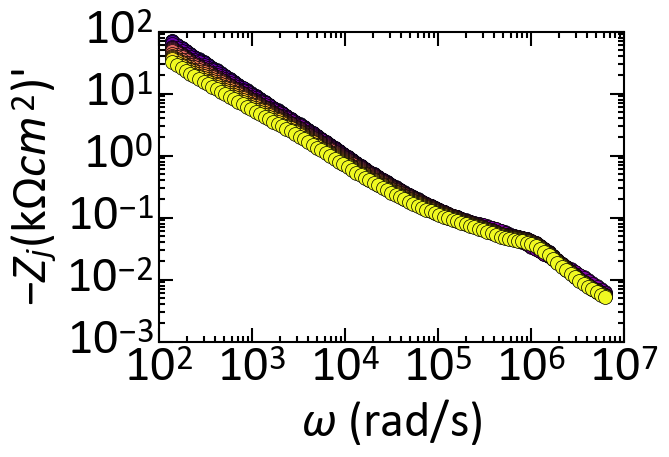

In [11]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(Zr(t),-Zi(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,90])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmagadj(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phiadj(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zr(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),abs(-Zi(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

Now try the 500 mV data

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


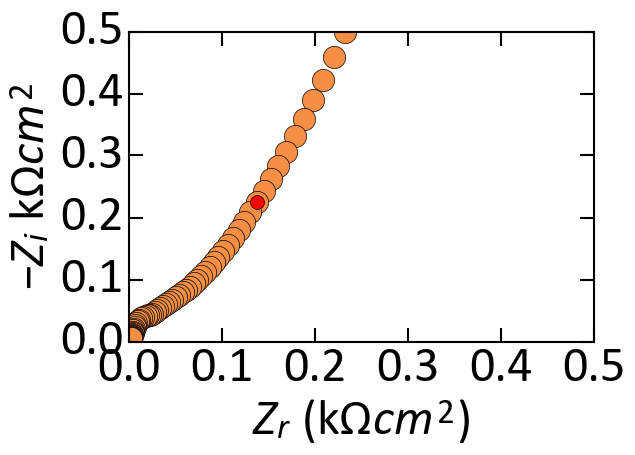

In [9]:
# we first need to put bounds on the recombination arcs. recall that we want to fit a certain temperature range.

# input temperature offsets for 400, 500, 600 mV
off4 = 13
off5 = 11
off6 = 8

# ID the proper ranges

# set up arrays
bounds4a = np.zeros(tmax)
bounds5a = np.zeros(tmax)
bounds6a = np.zeros(tmax)

bounds4b = np.zeros(tmax)
bounds5b = np.zeros(tmax)
bounds6b = np.zeros(tmax)


Tt = 11

fig,ax = plt.subplots(1,1)
ax.plot(Zr600(Tt)[:],-Zi600(Tt)[:],'o', color = tuple(colSet[Tt]))
ax.plot(Zr600(Tt)[-50],-Zi600(Tt)[-50],'ro', markersize = 10)

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0, 0.5, 0, 0.5])
# plt.savefig('nyquist_all_zoom.png')

bounds4a[13] = 0
bounds4a[14] = 0
bounds4a[15] = 0

bounds4b[13] = -50
bounds4b[14] = -50
bounds4b[15] = -50

bounds5a[11] = 0
bounds5a[12] = 0
bounds5a[13] = 0
bounds5a[14] = 0
bounds5a[15] = 0

bounds5b[11] = -50
bounds5b[12] = -50
bounds5b[13] = -50
bounds5b[14] = -50
bounds5b[15] = -50

bounds6a[11] = 0
bounds6a[12] = 0
bounds6a[13] = 0
bounds6a[14] = 0
bounds6a[15] = 0

bounds6b[11] = -50
bounds6b[12] = -50
bounds6b[13] = -50
bounds6b[14] = -50
bounds6b[15] = -50



With our offsets set, let's go ahead and make the guesses. 

Note that we are using a quick and dirty method to gain estimates for the parameters. Note that we are starting with high temperature data, since the reactive arc features are most apparent at high $T$.

Also note that we are not provided a guess for $\alpha$. We can of course provide one by fitting the slope of one side of the peak, but let's see if we can get away with not doing that since it takes a while.

In [10]:
Tt4 = 13

Tt5 = 11

# define a function that allows us to get the index of values read off the Nyquist plot so we know where to bound 
# the function in frequency
def Zr4Idx(T,val):
    return max(np.where(Zr400(T) <= val))[0]

def Zr5Idx(T,val):
    return max(np.where(Zr500(T) <= val))[0]

def Zr6Idx(T,val):
    return max(np.where(Zr600(T) <= val))[0]


zbound4_1 = Zr4Idx(Tt4,12)
zbound4_2 = Zr4Idx(Tt4,0.12)

zbound5_1 = Zr5Idx(Tt5,11)
zbound5_2 = Zr5Idx(Tt5,0.15)

zbound6_1 = Zr6Idx(Tt5,2.7)
zbound6_2 = Zr6Idx(Tt5,0.15)

# guesses for charge transfer resistance based on arc radii.
guessRct4 = abs(Zr400(Tt)[zbound4_2] - Zr400(Tt)[zbound4_1])
guessRct5 = abs(Zr500(Tt)[zbound5_2] - Zr500(Tt)[zbound5_1])
guessRct6 = abs(Zr600(Tt)[zbound6_2] - Zr600(Tt)[zbound6_1])
 
print(guessRct4)
print(guessRct5)
print(guessRct6)

# guess values for omega 0
w0Idx_4 = Zr4Idx(Tt,6)
w0guess4 = w(Tt)[w0Idx_4]

w0Idx_5 = Zr5Idx(Tt,8)
w0guess5 = w(Tt)[w0Idx_5]

w0Idx_6 = Zr6Idx(Tt,7)
w0guess6 = w(Tt)[w0Idx_6]

# guess for Q based on peak freq of each arc and Rct guesses above. 
guessQ4 = 1/(guessRct4*w0guess4)
guessQ5 = 1/(guessRct5*w0guess5)
guessQ6 = 1/(guessRct6*w0guess6)

print(guessQ4)
print(guessQ5)
print(guessQ6)


14.7922799854
10.3071280541
2.41265897905
0.000182361435283
0.000359098842058
0.00153410729876


In [11]:
# define functions for the impedance of all circuit elements used in the analysis
# use a simple CPE. also include voigt element


# define a function for the impedance of a single RQ arc 
def arc(w,Rct,Q,alpha):
    return Rct/(1+((1j*w)**alpha)*Q*Rct)

# define a function for the impedace of a single RC arc
def voigt_el(w,Rct,tau):
    return Rct/(1+(1j*w*tau))

# define a function for the impedance of a series resistor
def seriesR(w,c):
    return c

from lmfit import Model
 


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 100
    # variables        = 4
    chi-square         = 0.02828151
    reduced chi-square = 2.9460e-04
    Akaike info crit   = -809.071723
    Bayesian info crit = -798.651042
[[Variables]]
    Rs_c:      0.11472081 +/- 0.00412984 (3.60%) (init = 0.3)
    a1_Rct:    2.84757096 +/- 0.00884744 (0.31%) (init = 2.412659)
    a1_Q:      5.1426e-04 +/- 7.7989e-06 (1.52%) (init = 0.001)
    a1_alpha:  0.92383084 +/- 0.00207623 (0.22%) (init = 0.95)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1_Q, a1_alpha)   = -0.955
    C(a1_Rct, a1_alpha) = -0.803
    C(a1_Rct, a1_Q)     =  0.727
    C(Rs_c, a1_Rct)     = -0.710
    C(Rs_c, a1_alpha)   =  0.617
    C(Rs_c, a1_Q)       = -0.428



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


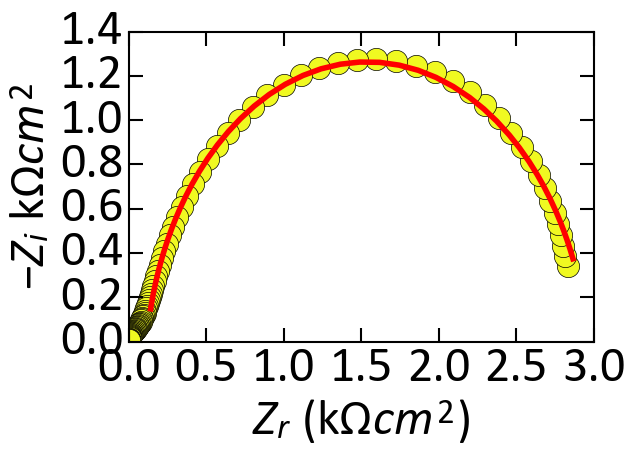

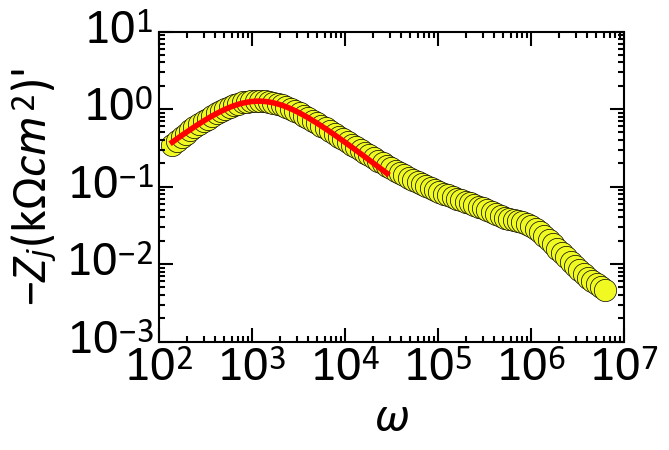

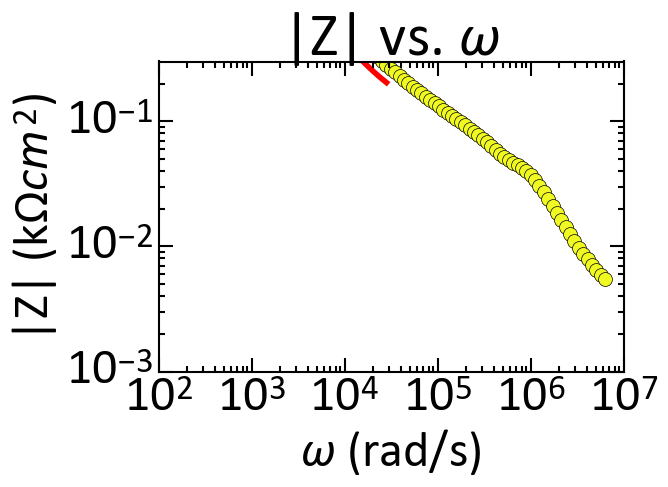

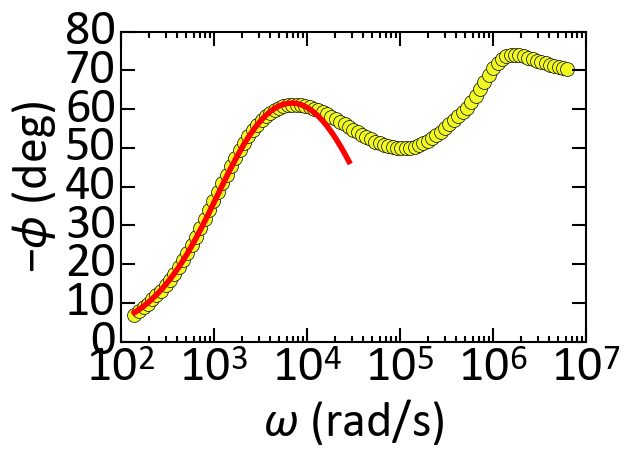

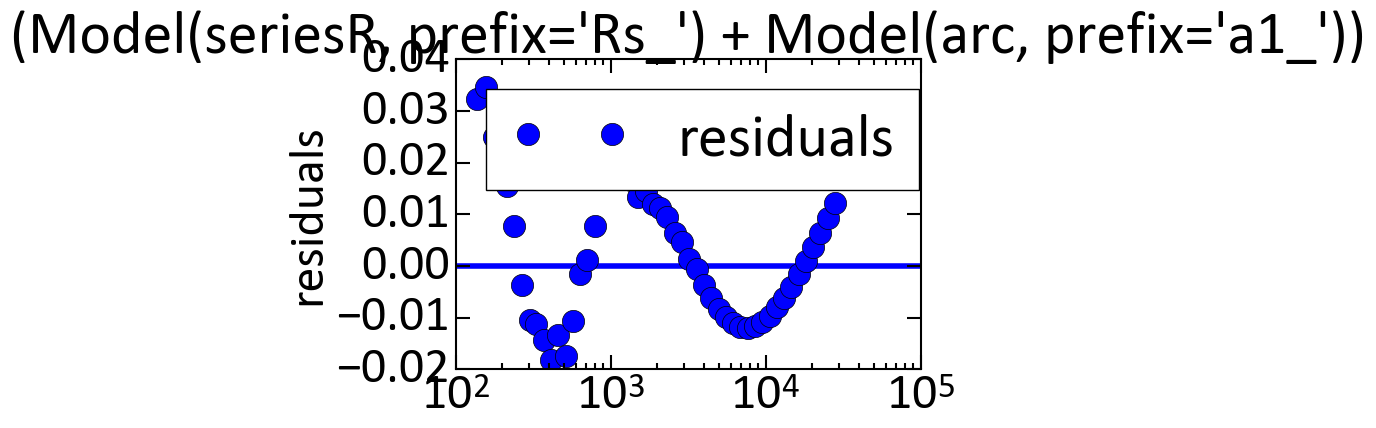

In [12]:
# define and run the models. 

# voigt model 
voigt1 = Model(voigt_el,prefix = 'v1_')
voigt2 = Model(voigt_el,prefix = 'v2_')
voigt3 = Model(voigt_el,prefix ='v3_')

# CPE model
arc1 = Model(arc,prefix ='a1_')

# series resistor
Rs = Model(seriesR,prefix = 'Rs_')

# define the aggregate voigt model
vModel = Rs + voigt1 + voigt2 + voigt3 

# define the aggregate CPE model
cModel = Rs + arc1


# start with 600 mV data.
# add parameters with guesses at lowest temperature. 
params = lmf.Parameters()  

params.add('Rs_c',value =  0.3, min = 0, max = 5)
params.add('a1_Rct',value = abs(guessRct6), min = 0, max = 5)
params.add('a1_Q',value = abs(guessQ6), min = 0, max = 1e-3)
params.add('a1_alpha',value = 0.95 , min = 0, max = 1)


# make the data complex and enter weights
data = Zr600(15)[bounds6a[15]:bounds6b[15]]+1j*Zi600(15)[bounds6a[15]:bounds6b[15]]
weights = 1/(.05*Zmag600(15)[bounds6a[15]:bounds6b[15]])


#try the fit
# fit_result = cModel.fit(data, w = w(Tt),params = params, weights = weights)
fit_result = cModel.fit(data, w = w(15)[bounds6a[15]:bounds6b[15]],params = params)
print(fit_result.fit_report())

# store the Rs fit value to check the phase angle plot
# RsFit = fit_result.params['Rs_c'].value

# make arrays that store the real and imaginary parts, magnitude, and phase (both raw and adjusted)
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)
phiFit = -np.arctan(imFit/reFit)*(180/np.pi)
# phiFitAdj = -np.arctan(imFit/(reFit - RsFit))*(180/np.pi)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr600(15),-Zi600(15),'o', color = tuple(colSet[15]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi600(15)),'o', color = tuple(colSet[15]))
ax.plot(w(15)[bounds6a[15]:bounds6b[15]],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(15),Zmag600(Tt),'o',c = tuple(colSet[15]), markersize = 10) 
ax.plot(w(15)[bounds6a[15]:bounds6b[15]],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(15),phi600(15),'o',c = tuple(colSet[15]), markersize = 10) 
ax.plot(w(15)[bounds6a[11]:bounds6b[15]],phiFit, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# # \phi_{adj} vs. \omega
# fig, ax = plt.subplots(1,1)
# ax.plot(w(11),phi600adj(11),'o',c = c, markersize = 10)
# ax.plot(w(11)[bounds6a[11]:bounds6b[11]],phiFitAdj, color = 'r')
# # ax.set_aspect('equal')
# ax.set_xlabel("$\omega$ (rad/s)")
# ax.set_ylabel("$-\phi$ (deg)")
# ax.set_xscale("log") 
# # ax.set_yscale("log") 
# # ax.set_title("$\phi_{adj}$ vs. $\omega$")
# #ax.set_xlim([0,1]);
# #ax.set_ylim([0,1]);
# # figName = '\\phaseAdj_400mV_all.png'
# # plt.savefig(figDir + figName,dpi = 300)

fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
fit_result.plot_residuals(ax=ax)


[0, 12, 0, 12]

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


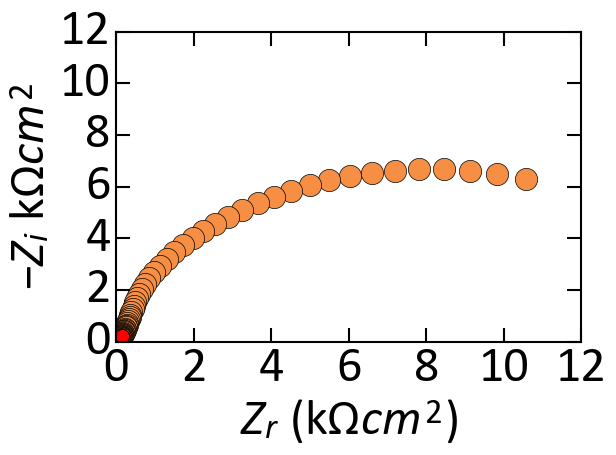

In [13]:

Tt = 11

fig,ax = plt.subplots(1,1)
ax.plot(Zr600(Tt)[:],-Zi600(Tt)[:],'o', color = tuple(colSet[Tt]))
ax.plot(Zr600(Tt)[-50],-Zi600(Tt)[-50],'ro', markersize = 10)

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0, 12, 0, 12])

In [14]:
# try for other low temperatures

zbound6_1 = Zr6Idx(Tt,14)
zbound6_2 = Zr6Idx(Tt,0.15)

# guesses for charge transfer resistance based on arc radii.
guessRct6 = 14
# print(guessRct6)

# guess values for omega 0
w0Idx_6 = Zr6Idx(Tt,7)
w0guess6 = w(Tt)[w0Idx_6]

# guess for Q based on peak freq of each arc and Rct guesses above. 
guessQ6 = 1/(guessRct6*w0guess6)



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 100
    # variables        = 4
    chi-square         = 0.59689470
    reduced chi-square = 0.00621765
    Akaike info crit   = -504.118476
    Bayesian info crit = -493.697795
[[Variables]]
    Rs_c:      0.03813905 +/- 0.01761239 (46.18%) (init = 0.3)
    a1_Rct:    16.4384050 +/- 0.12580590 (0.77%) (init = 14)
    a1_Q:      5.9336e-04 +/- 1.3222e-05 (2.23%) (init = 0.000264377)
    a1_alpha:  0.86835287 +/- 0.00383110 (0.44%) (init = 0.95)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1_Q, a1_alpha)   = -0.986
    C(a1_Rct, a1_Q)     =  0.879
    C(a1_Rct, a1_alpha) = -0.873
    C(Rs_c, a1_alpha)   =  0.602
    C(Rs_c, a1_Q)       = -0.510
    C(Rs_c, a1_Rct)     = -0.476



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


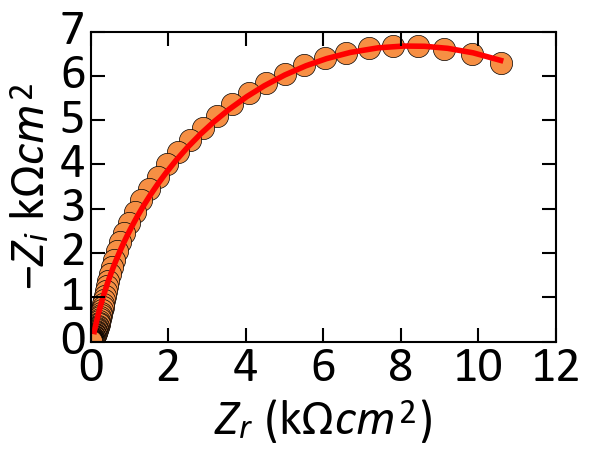

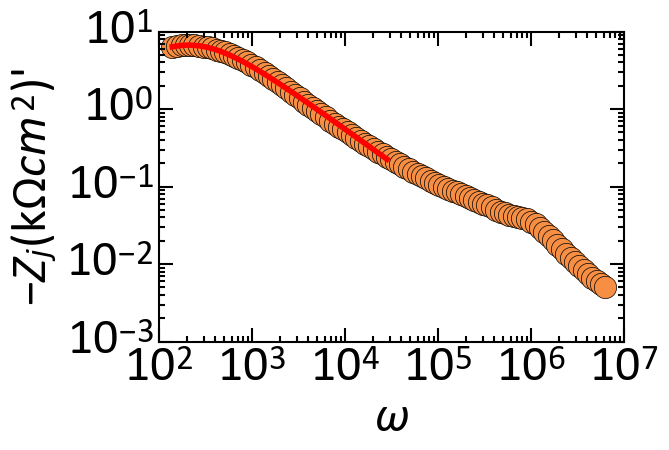

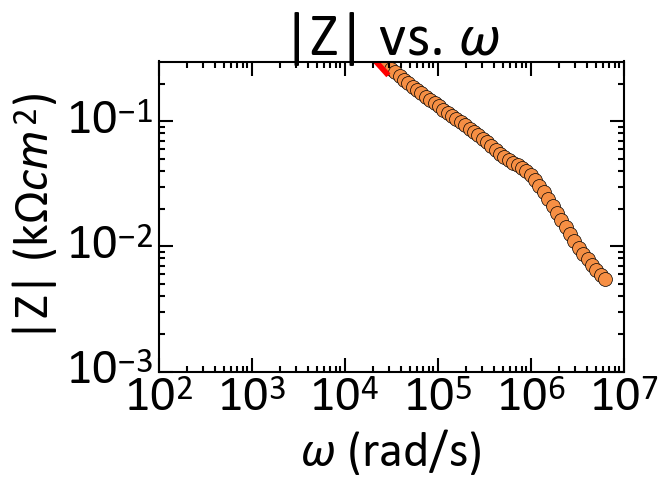

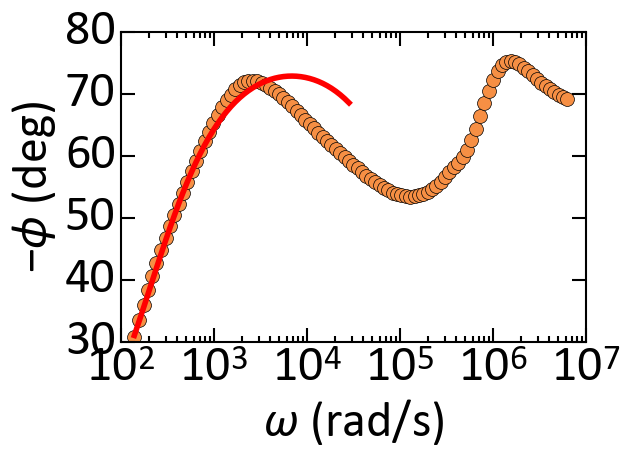

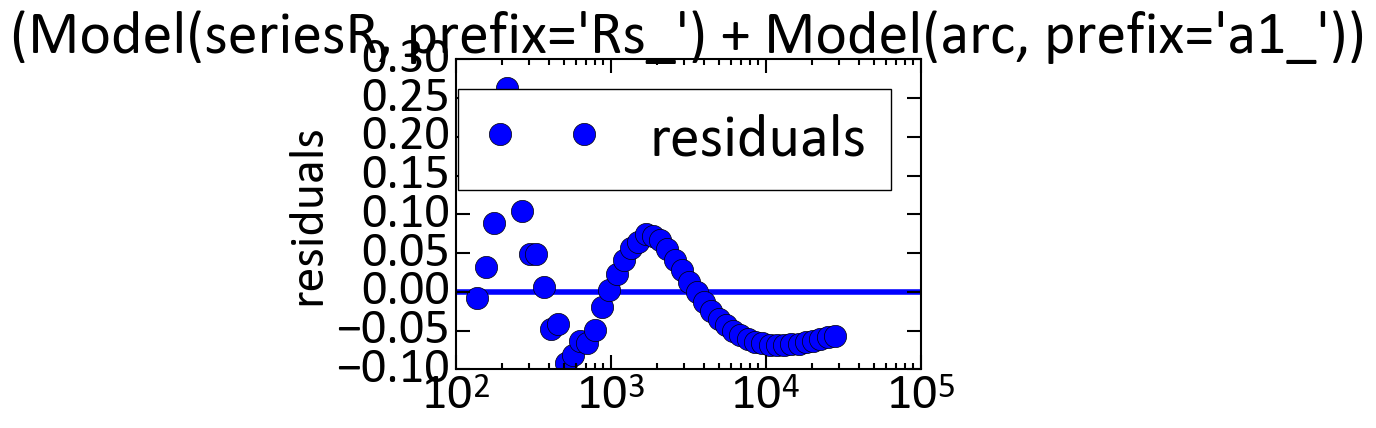

In [15]:
# start with 600 mV data.
# add parameters with guesses at lowest temperature. 
params = lmf.Parameters()  

params.add('Rs_c',value =  0.3, min = 0, max = 5)
params.add('a1_Rct',value = abs(guessRct6), min = 0, max = 20)
params.add('a1_Q',value = abs(guessQ6), min = 0, max = 1e-3)
params.add('a1_alpha',value = 0.95 , min = 0, max = 1)


# make the data complex and enter weights
data = Zr600(Tt)[bounds6a[Tt]:bounds6b[Tt]]+1j*Zi600(Tt)[bounds6a[Tt]:bounds6b[Tt]]
weights = 1/(.05*Zmag600(Tt)[bounds6a[Tt]:bounds6b[Tt]])


#try the fit
# fit_result = cModel.fit(data, w = w(Tt),params = params, weights = weights)
fit_result = cModel.fit(data, w = w(Tt)[bounds6a[Tt]:bounds6b[Tt]],params = params)
print(fit_result.fit_report())

# store the Rs fit value to check the phase angle plot
# RsFit = fit_result.params['Rs_c'].value

# make arrays that store the real and imaginary parts, magnitude, and phase (both raw and adjusted)
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)
phiFit = -np.arctan(imFit/reFit)*(180/np.pi)
# phiFitAdj = -np.arctan(imFit/(reFit - RsFit))*(180/np.pi)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr600(Tt),-Zi600(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi600(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds6a[Tt]:bounds6b[Tt]],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag600(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds6a[Tt]:bounds6b[Tt]],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi600(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds6a[Tt]:bounds6b[Tt]],phiFit, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
fit_result.plot_residuals(ax=ax)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


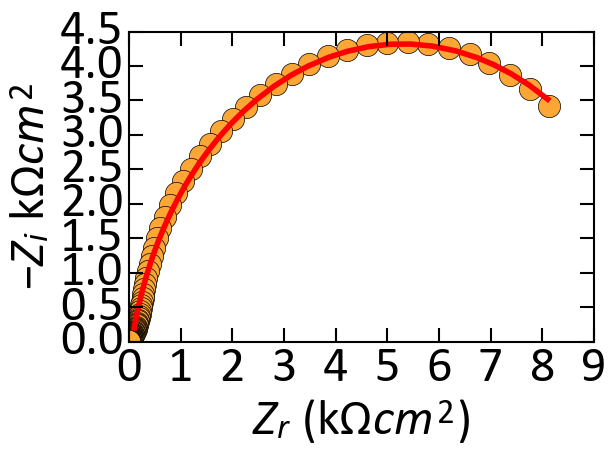

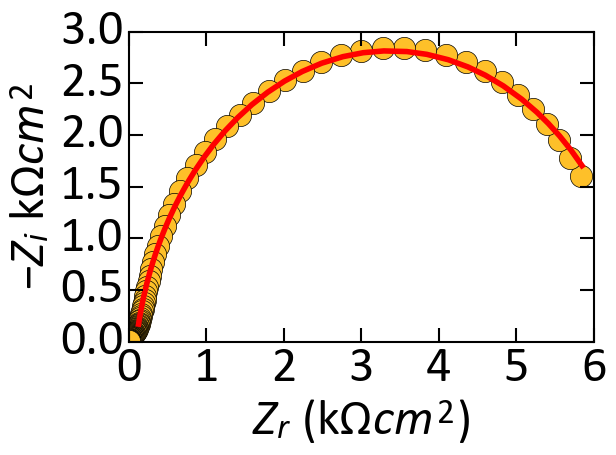

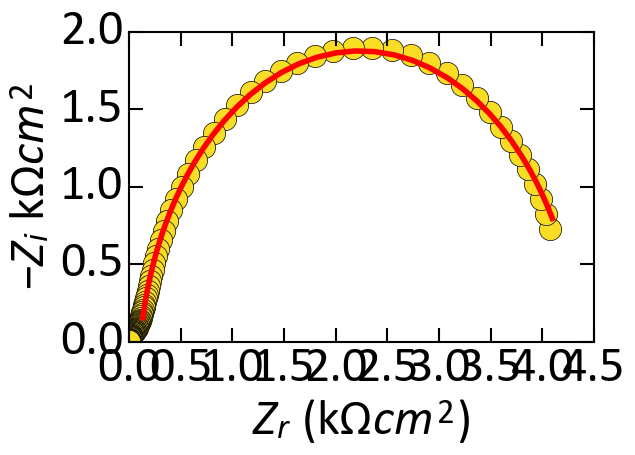

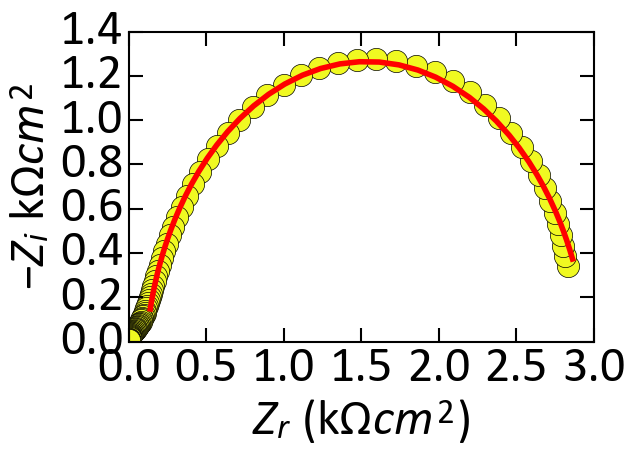

In [16]:
#ok with this done let's start fitting in a loop. recall again this is the 600 mV data 

# empty arrays for storing fit parameters
RsFits = []
RctFits = []
QFits = []
alphaFits =[]
fitResults = []

# store initial fit values
RsFits.append(fit_result.params['Rs_c'].value)
RctFits.append(fit_result.params['a1_Rct'].value)
QFits.append(fit_result.params['a1_Q'].value)
alphaFits.append(fit_result.params['a1_alpha'].value)
fitResults.append(fit_result)

for t in range(Tt+1,tmax):
    params = lmf.Parameters() 
    params.add('Rs_c',value = RsFits[t-12], min = 0, max = 5)
    params.add('a1_Rct',value = RctFits[t-12], min = 0, max = 100)
    params.add('a1_Q',value = QFits[t-12], min = 0, max = 1e-3)
    params.add('a1_alpha',value = alphaFits[t-12] , min = 0, max = 1)
    
    #data and weights
    data = Zr600(t)[bounds6a[t]:bounds6b[t]]+1j*Zi600(t)[bounds6a[t]:bounds6b[t]]
    weights = 1/(.05*Zmag600(t)[bounds6a[t]:bounds6b[t]])
    
    #run the fit
    fit_result = cModel.fit(data, w = w(t)[bounds6a[t]:bounds6b[t]],params = params)
         
    #store parameters and fits
    RsFits.append(fit_result.params['Rs_c'].value)
    RctFits.append(fit_result.params['a1_Rct'].value)
    QFits.append(fit_result.params['a1_Q'].value)
    alphaFits.append(fit_result.params['a1_alpha'].value)
    fitResults.append(fit_result)

    # plot the resulting fit
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr600(t),-Zi600(t),'o', color = tuple(colSet[t]))
    ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
    



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


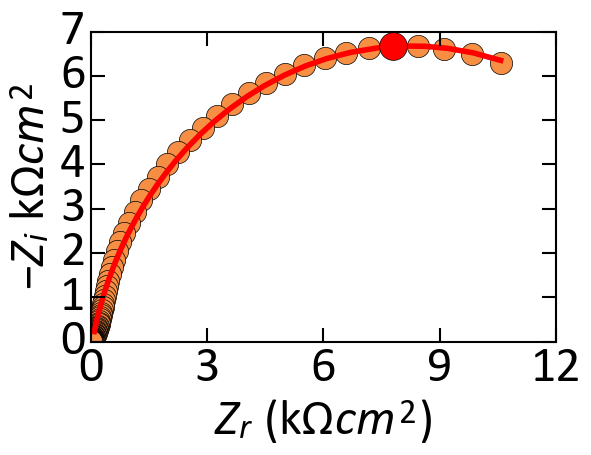

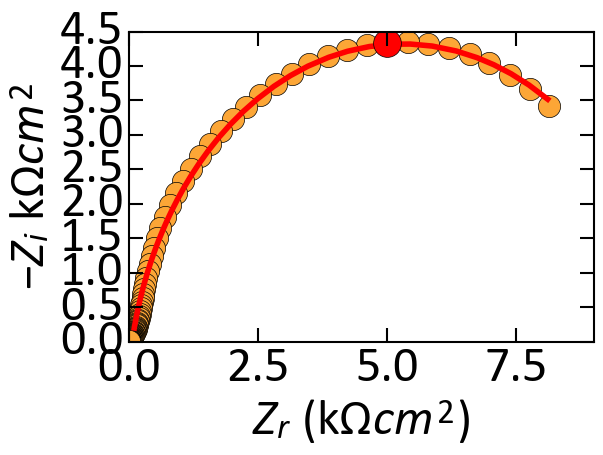

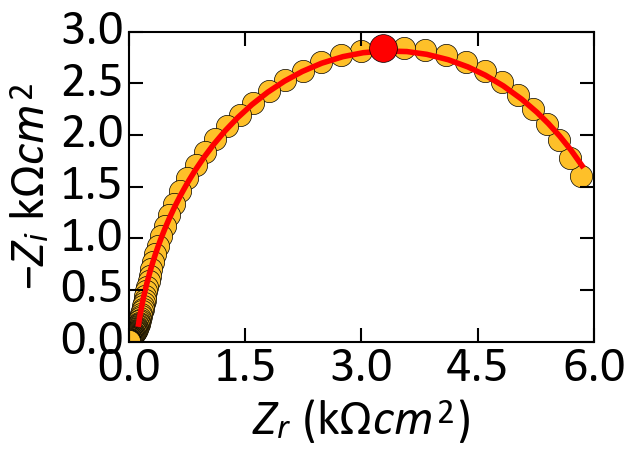

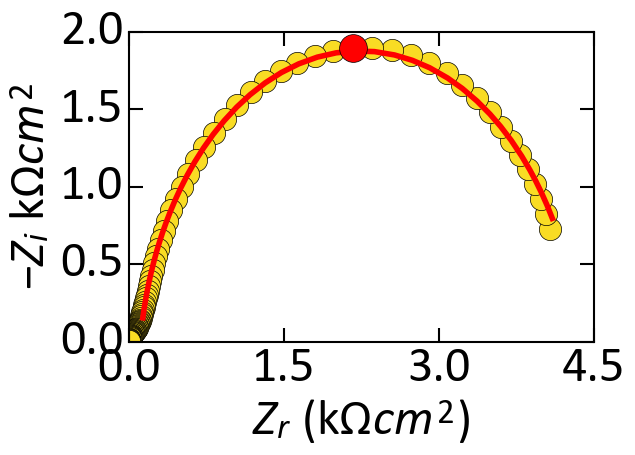

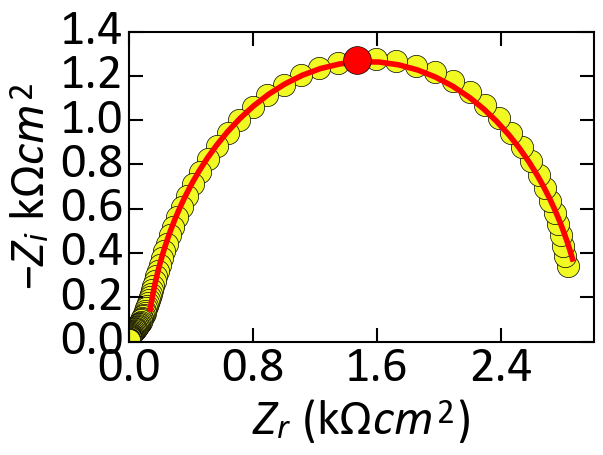

In [17]:
# first make all the fit parameters np arrays to keep track of the data types
alphaFit = np.asarray(alphaFits)
QFit = np.asarray(QFits)
RsFit = np.asarray(RsFits)
RctFit = np.asarray(RctFits)

# now do the calculation. obtain both tau and the index of w0
tau = np.zeros(tmax-Tt)
wt0 = np.zeros(tmax-Tt)
for t in range(0,tmax-Tt):
    tau[t] = [QFit[t]*RctFit[t]]**(1/alphaFit[t])
    wt0[t] = np.argmax(w(t) > (1/tau[t]))
    
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr600(t+Tt),-Zi600(t+Tt),'o', color = tuple(colSet[t+Tt]))
    ax.plot(np.real(fitResults[t].best_fit),-np.imag(fitResults[t].best_fit),color = 'r')
    
    ax.plot(Zr600(t+Tt)[wt0[t]],-Zi600(t+Tt)[wt0[t]],'ro', markersize = 20)
    
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
    ax.xaxis.set_major_locator(MaxNLocator(4))
#     figName = '\\Zfit_'+ np.array2string(T[t+Tt].astype(int)) + '.png'
#     plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')
    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


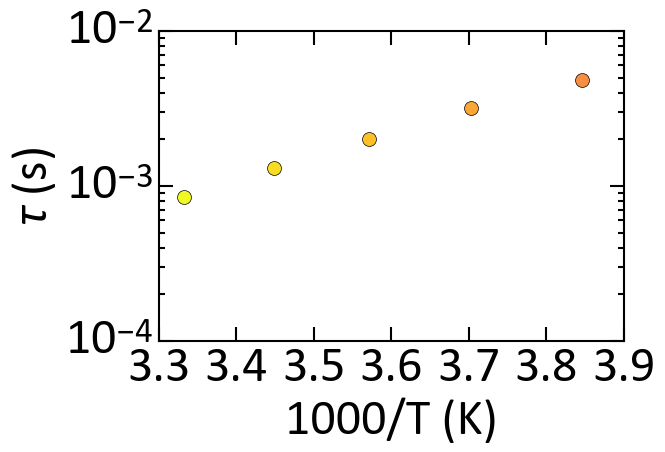

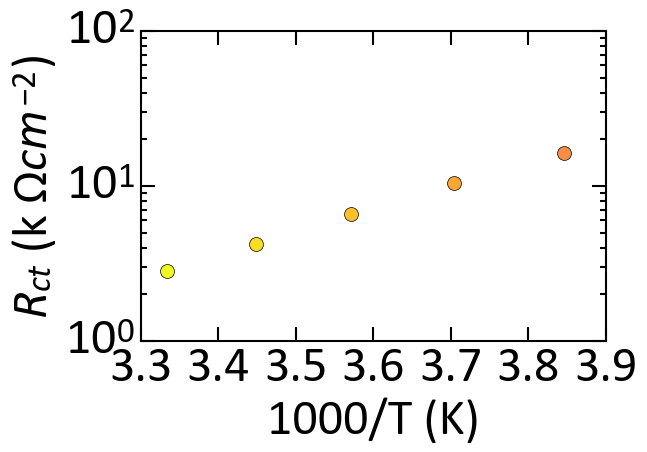

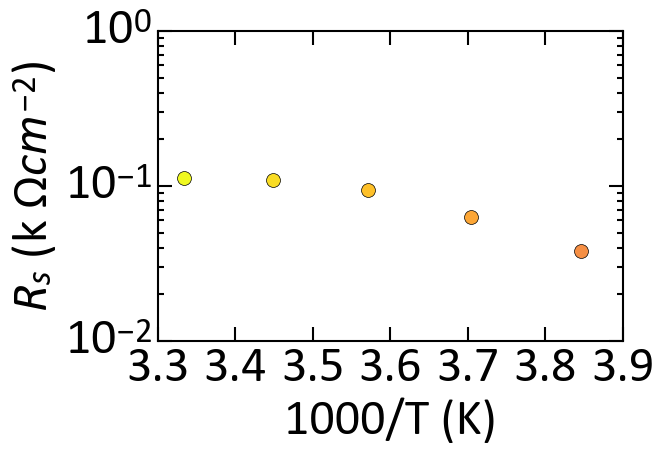

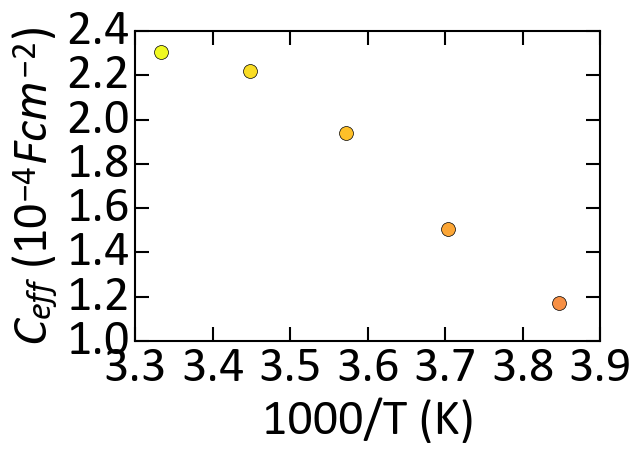

In [18]:
fig,ax = plt.subplots(1,1)
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],tau[t],'o',color=tuple(colSet[t+Tt]),markersize = 10)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],RctFits[t],'o',color=tuple(colSet[t+Tt]),markersize = 10)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],RsFits[t],'o',color=tuple(colSet[t+Tt]),markersize = 10)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{s}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')

# also calculate the effective capacitance (according to Brug, et. al.) and see if this matches with our intuition of what's happening
Ceff = np.zeros(tmax-Tt)
for t in range(0,tmax-Tt):
    Ceff[t] = [QFit[t]*((1/RsFit[t]) + (1/RctFit[t]))**(alphaFit[t]-1)]**(1/alphaFit[t])

fig,ax = plt.subplots(1,1)
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],Ceff[t]*1e4,'o',color=tuple(colSet[t+Tt]),markersize = 10)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_yscale('log')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


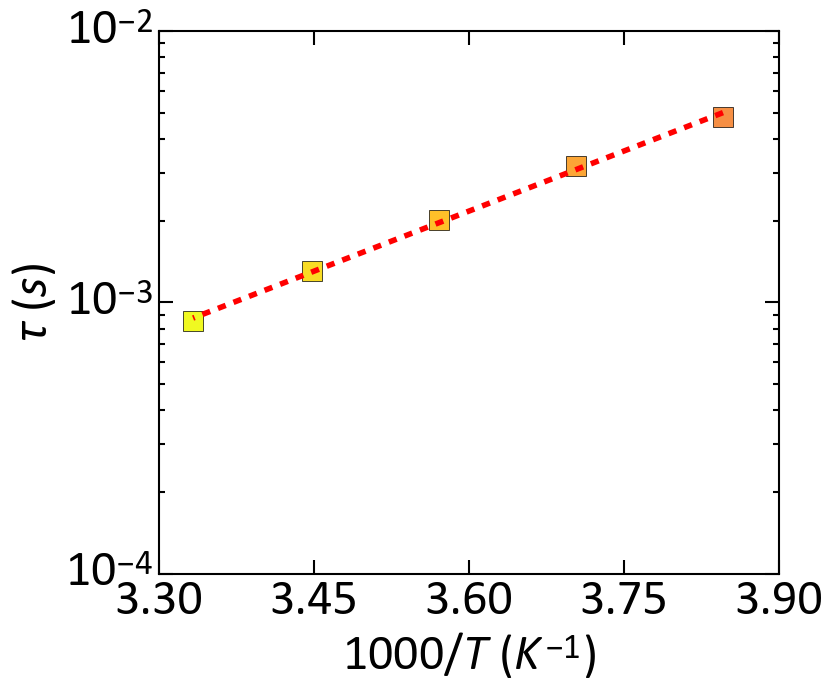

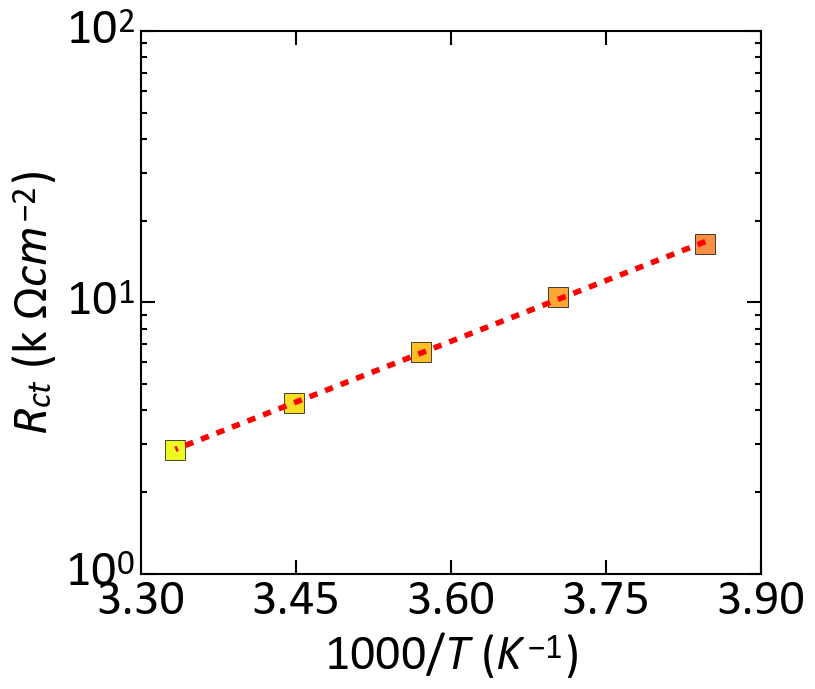

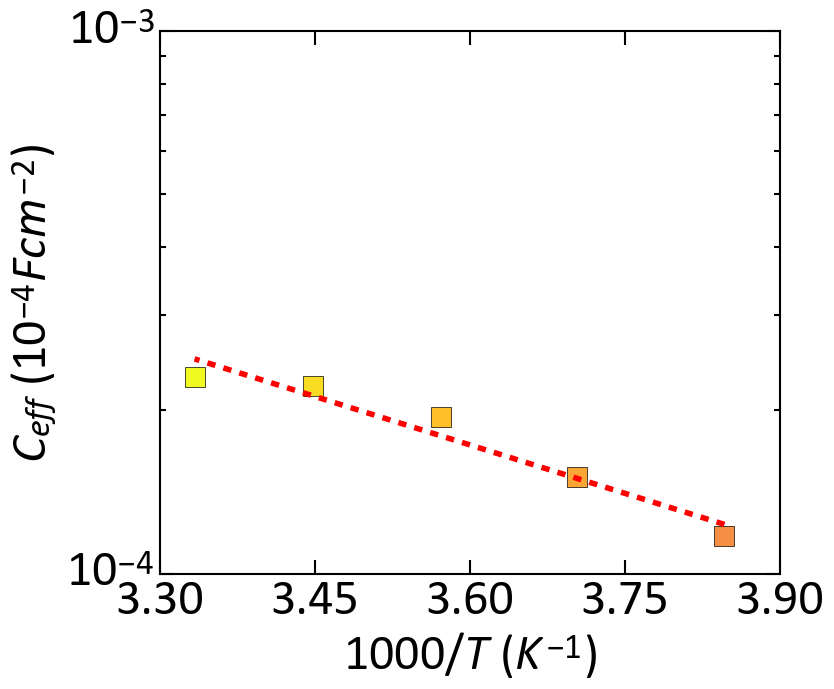

In [20]:
# fit to tau with error estimates
xt = np.vstack( [1e3/T[Tt:], np.ones(len(T[Tt:]))] ).T
yt = np.log(tau[:])

mt,ct = np.linalg.lstsq(xt,yt)[0]
Etau = np.abs((kB*mt)*1e3)
tauLine =  np.exp(mt*(1e3/T[Tt:])) * np.exp(ct)
tauCoeff = np.array([mt, ct])
# error estimates
dLen_tau = len(yt)
tauCoeffLen = len(tauCoeff)
rmse_tau = np.sum((yt - np.dot(xt,tauCoeff))**2)/(dLen_tau-tauCoeffLen)
covMat_tau = rmse_tau*np.linalg.inv(np.dot(xt.T,xt))
stdErr_tau = np.sqrt(np.diagonal(covMat_tau))
EtauErr = stdErr_tau[1]*Etau


# fit to capacitance with error estimates
xC = np.vstack( [1e3/T[Tt:], np.ones(len(T[Tt:]))] ).T
yC = np.log(Ceff[:])

mC,cC = np.linalg.lstsq(xC,yC)[0]
Ecap = np.abs((kB*mC)*1e3)
cLine =  np.exp(mC*(1e3/T[Tt:])) * np.exp(cC)
cCoeff = np.array([mC, cC])
# error estimates
dLen_c = len(yt)
capCoeffLen = len(cCoeff)
rmse_cap = np.sum((yC - np.dot(xC,cCoeff))**2)/(dLen_c-capCoeffLen)
covMat_cap = rmse_cap*np.linalg.inv(np.dot(xC.T,xC))
stdErr_cap = np.sqrt(np.diagonal(covMat_cap))
EcapErr = stdErr_cap[1]*Ecap

# fit to resistance with error estimates
xR = np.vstack( [1e3/T[Tt:], np.ones(len(T[Tt:]))] ).T
yR = np.log(RctFits[:])

mR,cR = np.linalg.lstsq(xR,yR)[0]
Er = np.abs((kB*mR)*1e3)
rLine =  np.exp(mR*(1e3/T[Tt:])) * np.exp(cR)
rCoeff = np.array([mR, cR])
# error estimates
dLen_r = len(yR)
rCoeffLen = len(rCoeff)
rmse_r = np.sum((yR - np.dot(xR,rCoeff))**2)/(dLen_r-rCoeffLen)
covMat_r = rmse_r*np.linalg.inv(np.dot(xR.T,xR))
stdErr_r = np.sqrt(np.diagonal(covMat_r))
ErErr = stdErr_r[1]*Er

# plot tau data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],tau[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],tauLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\tau$ ($s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\tau_arrheniusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot Rct data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],RctFits[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],rLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\R_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot Rct data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],Ceff[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],cLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\C_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')



# # plot tau data and fit
# fig,ax = plt.subplots(1,1, figsize = (8,7))
# for t in range(0,tmax-Tt):
#     ax.plot(1e3/T[t+Tt],tau[t],'o',color=tuple(colSet[t+Tt]),markersize = 15)

# ax.plot(1e3/T[Tt:],Line[:],color = 'r',linestyle='dashed' )

# ax.set_xlabel("$1000/T$ ($K^{-1}$)")
# ax.set_ylabel("$\\tau$ ($s$)")
# # ax.set_xscale('log')
# ax.set_yscale('log')
# # ax.yaxis.set_major_locator(MaxNLocator(4))
# ax.xaxis.set_major_locator(MaxNLocator(5))
# # ax.set_xlim([180,300])
# # ax.set_ylim([0,4])
# figName = '\\sigmaArrFits_multiW.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')



In [21]:
print('Activation of tau: {}'.format(Etau) + ' +\- {}'.format(EtauErr))
print('Activation of R: {}'.format(Er) + ' +\- {}'.format(ErErr))
print('Activation of C: {}'.format(Ecap) + ' +\- {}'.format(EcapErr))

Activation of tau: 0.2930038379845961 +\- 0.08426872789764997
Activation of R: 0.29626231893732036 +\- 0.04380682265212759
Activation of C: 0.11807037103946019 +\- 0.07690551516203839


In [22]:
print(alphaFit)

[ 0.86835287  0.87898218  0.90335981  0.92003478  0.92490951]


In [27]:
print(QFit)

[ 0.00059336  0.00061059  0.00055729  0.00051945  0.00051049]


In [28]:
print(RctFit)

[ 16.43840504  10.46120263   6.55209286   4.25296019   2.84586941]


In [29]:
print(RsFit)

[ 0.03813905  0.06288527  0.0947639   0.11012046  0.11265695]


In [30]:
print(tau)

[ 0.00483421  0.00318547  0.00200308  0.0012984   0.0008547 ]


In [23]:
print(figDir)

C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\MPA\09_2016_m1\dev2\analysis\figures\impedance


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


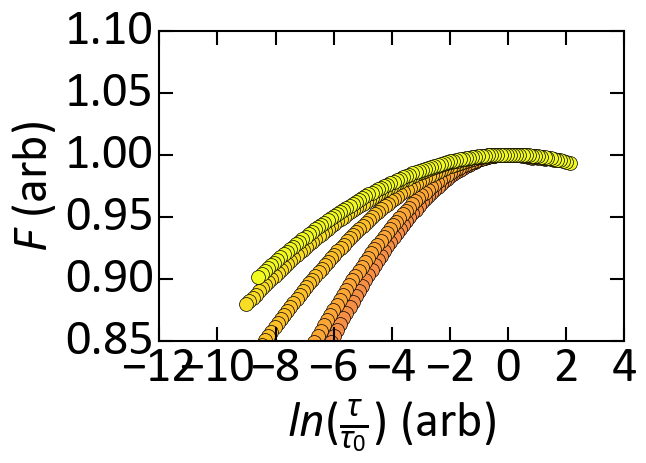

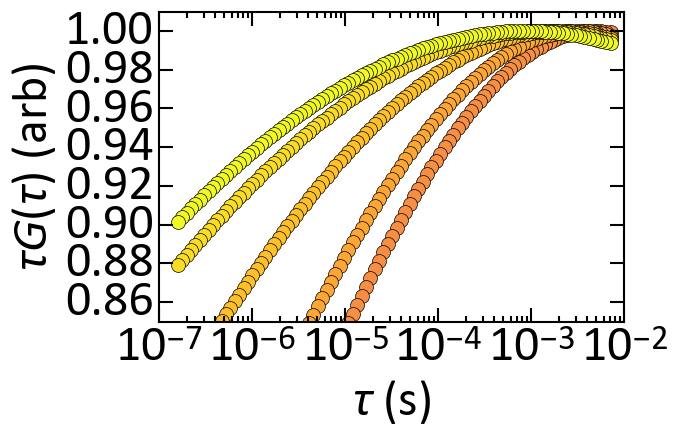

In [24]:
# calculate and plot the distribution of lifetimes G(\tau)

tauArray = 1/w(1)[:]
G = np.zeros((w(1).shape[0],5))
Gnorm = np.zeros((w(1).shape[0],5))
sArray = np.zeros((w(1).shape[0],5))
F = np.zeros((w(1).shape[0],5))
Fnorm = np.zeros((w(1).shape[0],5))
tG = np.zeros((w(1).shape[0],5))
tGnorm = np.zeros((w(1).shape[0],5))

# calculate the distribution for 200 different lifetimes that span from 1 order of magnitude above the largest \tau and 1 
# order of magnitude smaller than the lowest \tau
for t in range(0,5):
    G[:,t] = (1/(2*np.pi*tauArray[:]))*((np.sin(np.pi*alphaFit[t]))/(np.cosh((1-alphaFit[t])*np.log(tauArray[:]/tau[t])) - np.cos(alphaFit[t]*np.pi))) 
    Gnorm[:,t] = G[:,t]/np.amax(G[:,t])
    
    sArray[:,t] = np.log(tauArray[:]/tau[t])
    
    F[:,t] = ((np.sin(np.pi*alphaFit[t]))/(np.cosh((1-alphaFit[t])*np.log(tauArray[:]/tau[t])) - np.cos(alphaFit[t]*np.pi)))
    Fnorm[:,t] = F[:,t]/np.amax(F[:,t])   
    
    tG[:,t] = tauArray*G[:,t]
    tGnorm[:,t] = tG[:,t]/np.amax(tG[:,t])
    
    
# first plot the F function, which is a **normal** distribution of ln((\tau)/(\tau_0))    
fig,ax = plt.subplots(1,1)
for t in range(0,5):
    ax.plot(sArray[:,t],Fnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+11]))
#     ax.plot(tauArray[:],Gnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+offSet]))
ax.set_xlabel("$ln(\\frac{\\tau}{\\tau_{0}}$) (arb)")
ax.set_ylabel("$F$ (arb)")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.1]);
# ax.set_xlim([-1,1e-3]);
# plt.savefig('F_distribution.png')


# now plot the G function, which is a power law function of \tau
fig,ax = plt.subplots(1,1)
for t in range(0,5):
    ax.plot(tauArray[:],tGnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+11]))
ax.set_xlabel("$\\tau$ (s)")
ax.set_ylabel("$\\tau G(\\tau)$ (arb)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.01]);
# ax.set_xlim([-1,1e-3]);
# plt.savefig('G_distribution.png')


## Figure Plots##


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


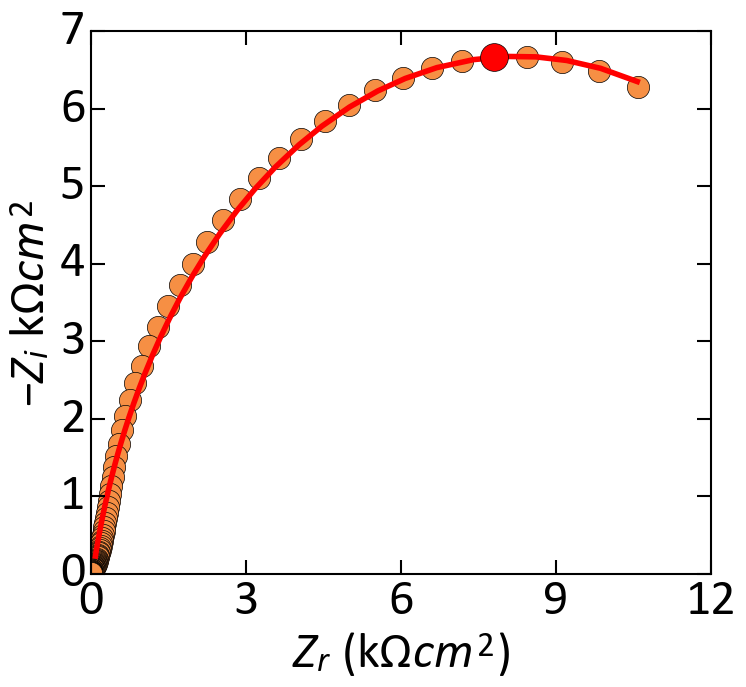

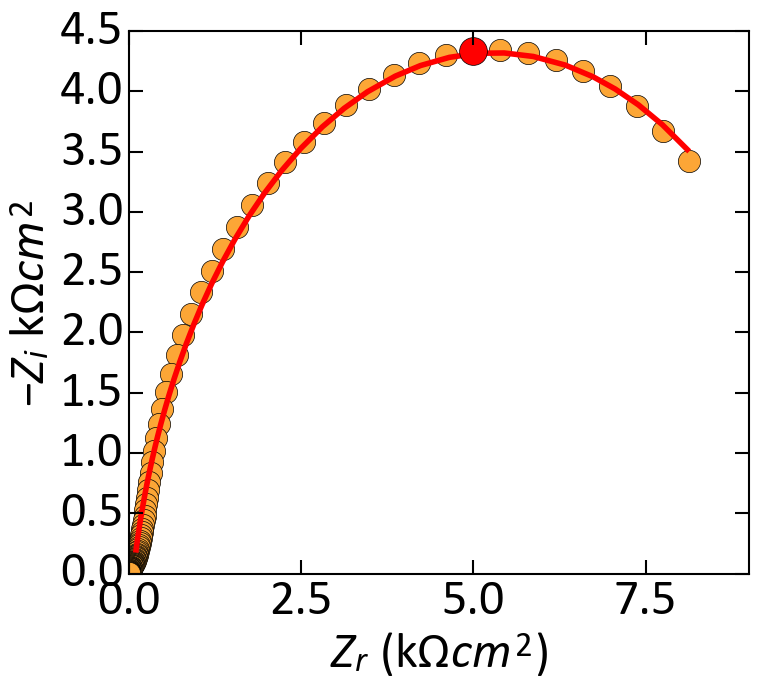

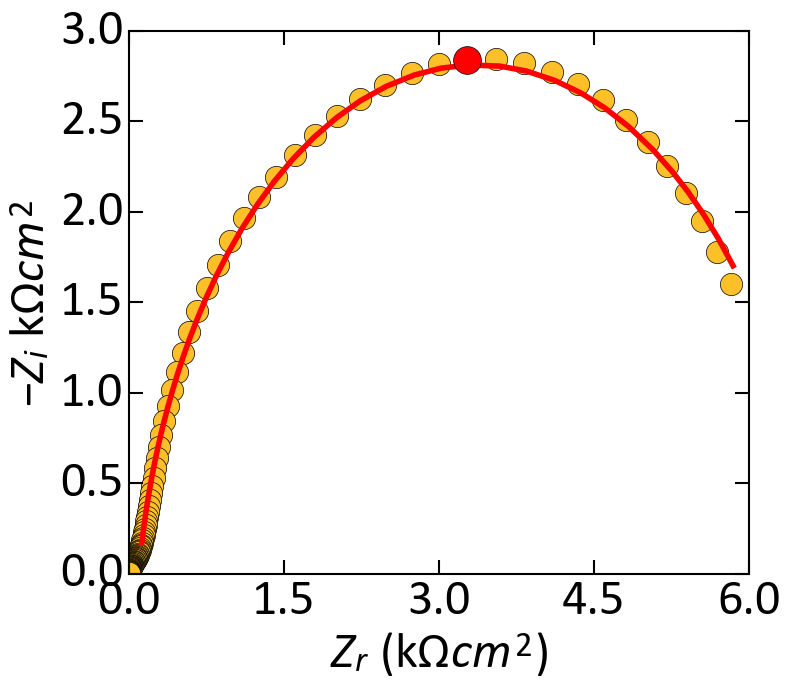

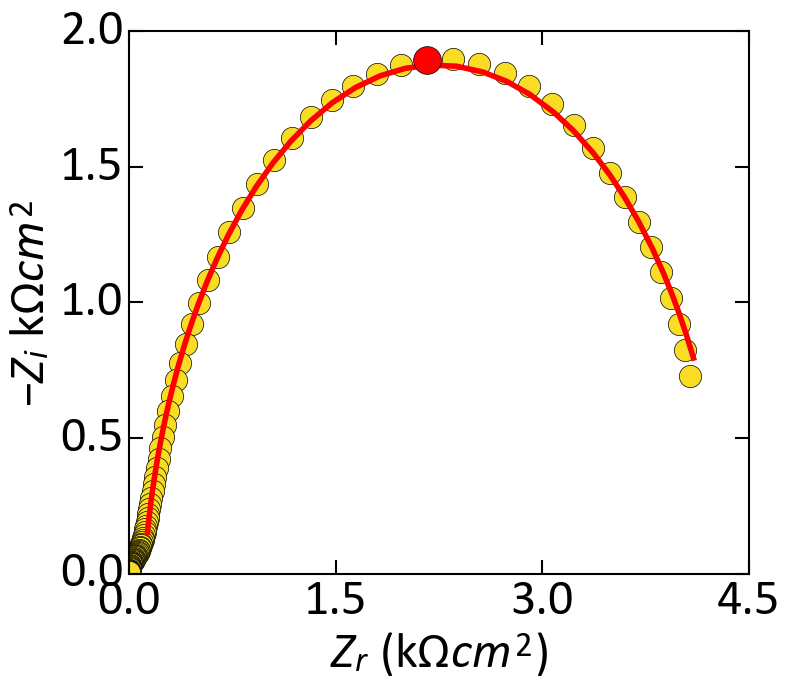

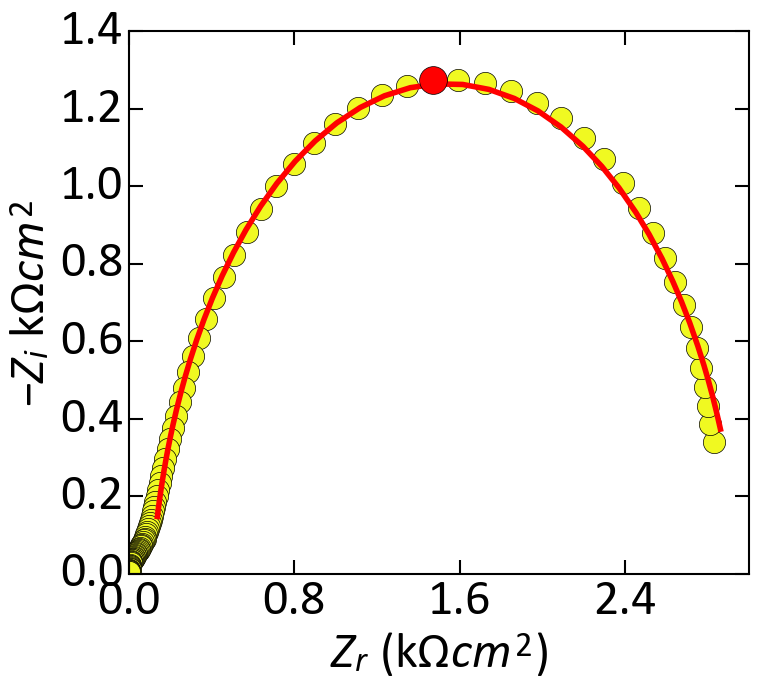

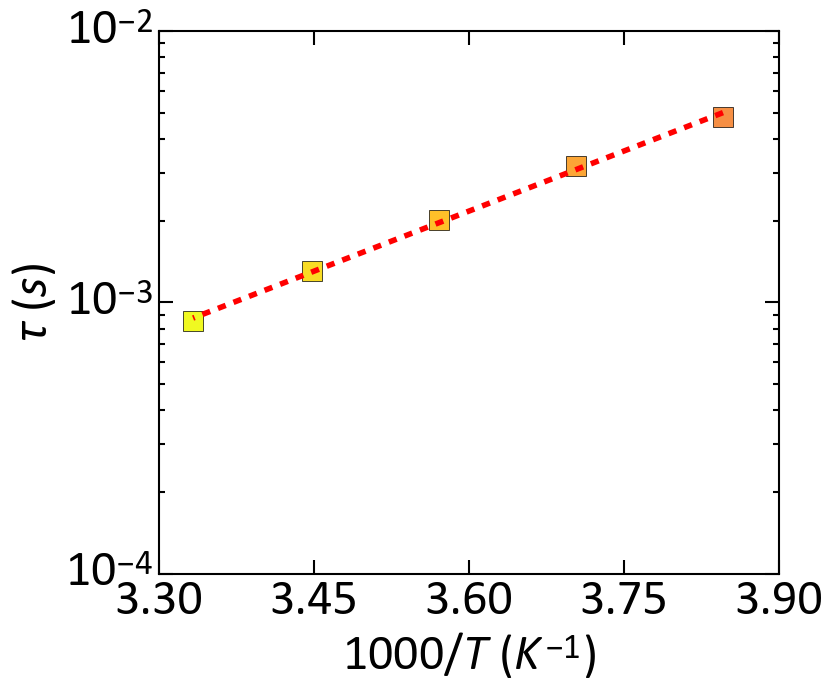

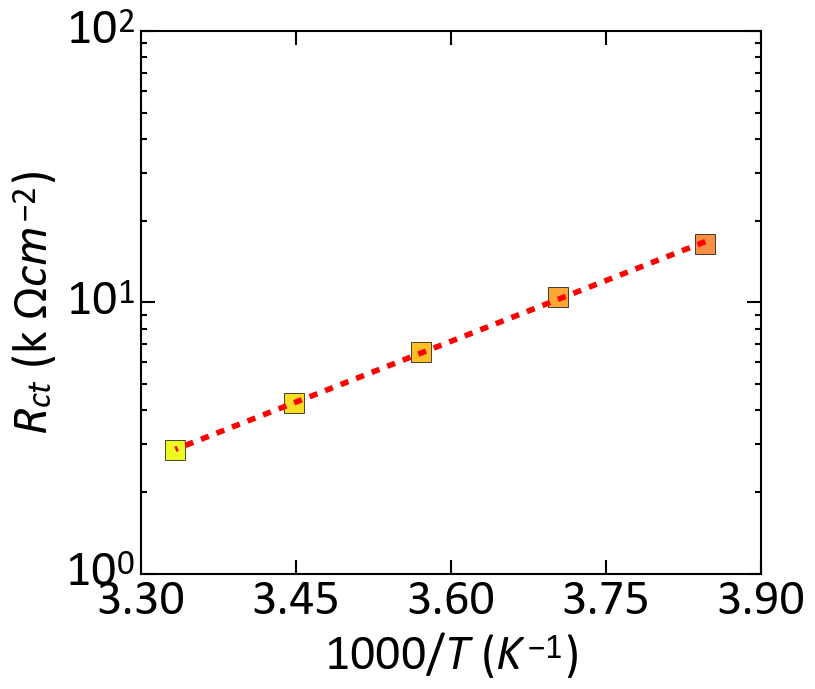

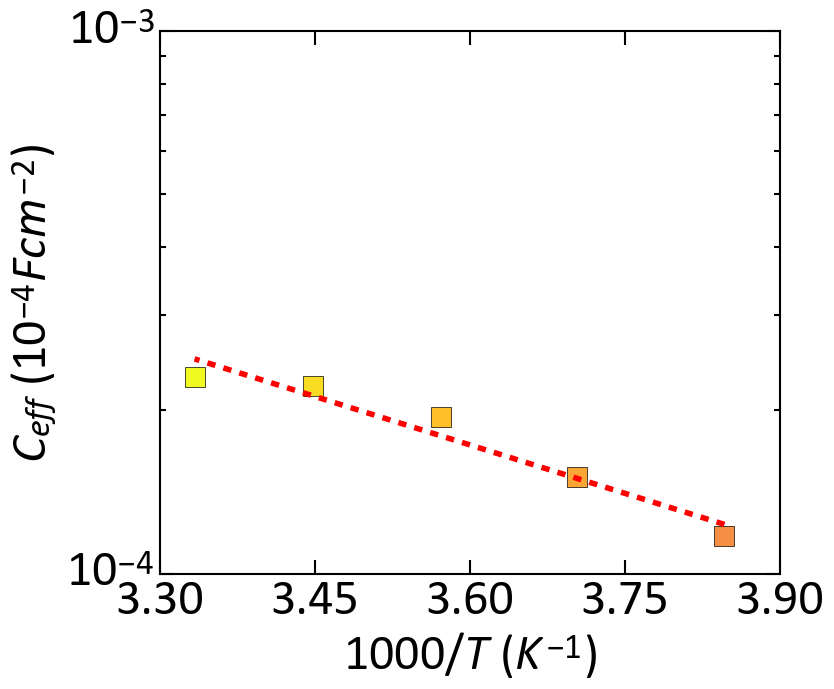

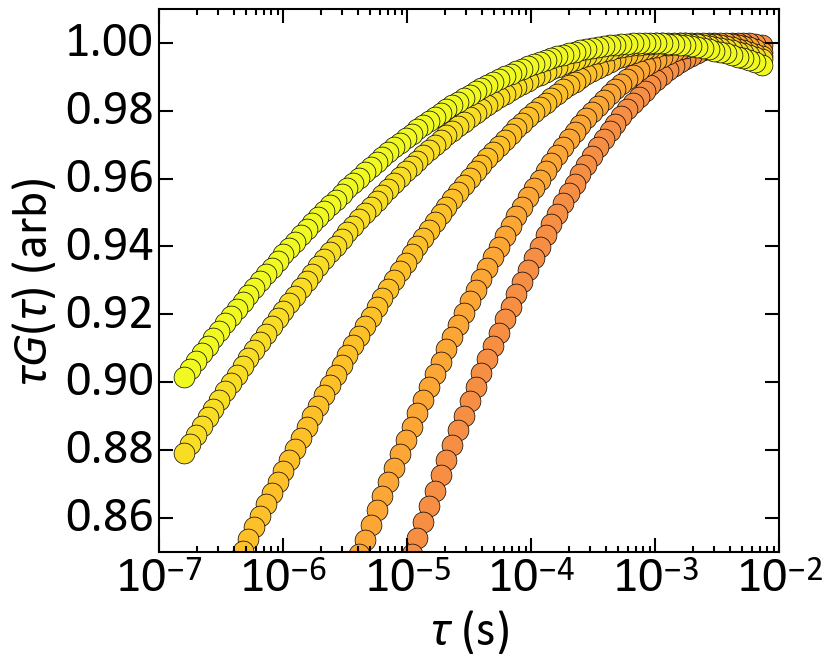

In [39]:
figDir2 = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\MPA\impedanceSpec'


# Fits to impedance arc
tau = np.zeros(tmax-Tt)
wt0 = np.zeros(tmax-Tt)
for t in range(0,tmax-Tt):
    tau[t] = [QFit[t]*RctFit[t]]**(1/alphaFit[t])
    wt0[t] = np.argmax(w(t) > (1/tau[t]))
    
    fig,ax = plt.subplots(1,1, figsize = (8,7))
    ax.plot(Zr600(t+Tt),-Zi600(t+Tt),'o', color = tuple(colSet[t+Tt]))
    ax.plot(np.real(fitResults[t].best_fit),-np.imag(fitResults[t].best_fit),color = 'r')
    
    ax.plot(Zr600(t+Tt)[wt0[t]],-Zi600(t+Tt)[wt0[t]],'ro', markersize = 20)
    
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
    ax.xaxis.set_major_locator(MaxNLocator(4))
#     figName = '\\Zfit_'+ np.array2string(T[t+Tt].astype(int)) + '.png'
#     plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')


# plot tau data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],tau[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],tauLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\tau$ ($s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\tau_arrheniusFit.png'
# plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')


# plot Rct data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],RctFits[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],rLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\R_arrhenhiusFit.png'
# plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')

# plot C data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax-Tt):
    ax.plot(1e3/T[t+Tt],Ceff[t],'s',color=tuple(colSet[t+Tt]),markersize = 15)

ax.plot(1e3/T[Tt:],cLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\C_arrhenhiusFit.png'
# plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')


# plot time constant distributions

# now plot the G function, which is a power law function of \tau
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,5):
    ax.plot(tauArray[:],tGnorm[:,t],'o', markersize = 15,color = tuple(colSet[t+11]))
ax.set_xlabel("$\\tau$ (s)")
ax.set_ylabel("$\\tau G(\\tau)$ (arb)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.01]);
# ax.set_xlim([-1,1e-3]);
# figName = '\\tau_dist.png'
# plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


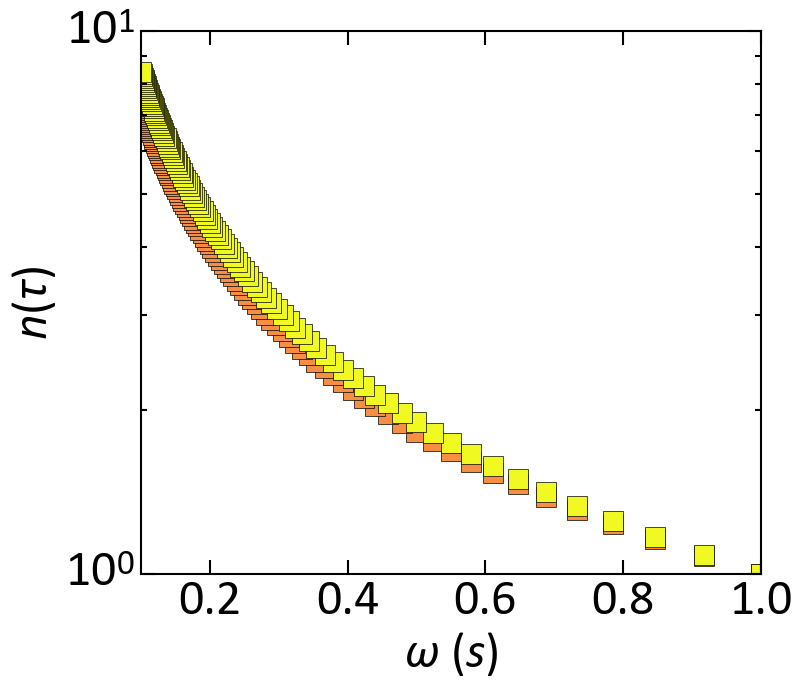

In [23]:
xTest = np.linspace(1,10,num = 100)

yTest1 = xTest**(alphaFit[0])
yTest2 = xTest**(alphaFit[4])


fig,ax = plt.subplots(1,1, figsize = (8,7))
ax.plot(1/xTest,yTest1,'s',color=tuple(colSet[11]),markersize = 15)
ax.plot(1/xTest,yTest2,'s',color=tuple(colSet[15]),markersize = 15)

ax.set_xlabel("$\\omega$ ($s$)")
ax.set_ylabel("$n(\\tau)$")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\C_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')



In [24]:
epsilon0= 8.854e-14

epsilonZ = 3.7

3.7*epsilon0*((1/29e-9))

1.1296482758620688e-05

In [25]:
29e-9*4e-2

1.1600000000000001e-09

In [26]:
#Zno depletion thickness calculation

# thickness of MPA layer in cm
D_pbs = 1.90e-5

# area of cell in cm
area = 4e-2

# epsilon of MPA
eps_r1 = 20

# epsilon of ZnO
eps_r2 = 3.7

# vacucum permittivity in cm
eps0 = 8.854e-14

# total geometric capacitance (high frequency plateau) in F
Ct = 1.16e-9


D_zno = eps0*eps_r2*area*((1/Ct) - (D_pbs/(eps0*eps_r1*area)))

print(D_zno)

7.78148275862069e-06


In [27]:
(3.7*eps0*area)/(Ct)

1.129648275862069e-05

In [29]:
(110/23)*(3.7*eps0*(7e4/2*np.pi))

1.722756939131839e-07

In [60]:
(3.7*eps0)/(140e-9)

2.339985714285714e-06

In [38]:
6e16*1e-3*1.602e-19

9.612e-06

In [35]:
(1.60e-8/(3.7*eps0))*(20/100)

9768.069402133104

In [36]:
7e4/(2*np.pi)

11140.846016432673

In [41]:
(1e4*3.7*eps0*1e-5)/2.5e-6

1.310392e-08

In [48]:
1/6.1e5

1.6393442622950819e-06

In [55]:
0.011/(1.602e-19*2e-3)

3.4332084893882642e+19

In [56]:
1.6e22/7.2e19

222.22222222222223

In [57]:
2e19/2.5e17

80.0

In [37]:
xD = np.array([270, 280, 290, 300]);

yD = np.array([128.6, 131.8, 135.8, 139.8]);

# fit to capacitance with error estimates
xD2 = np.vstack( [1e3/xD, np.ones(len(xD))] ).T
yD2 = np.log(yD)

md2,cd2 = np.linalg.lstsq(xD2,yD2)[0]
Ed2 = np.abs((kB*md2)*1e3)
d2Line =  np.exp(md2*(1e3/T[Tt:])) * np.exp(cd2)
d2Coeff = np.array([md2, cd2])
# error estimates
dLen_d2 = len(yD2)
d2_CoeffLen = len(d2Coeff)
rmse_d2 = np.sum((yt - np.dot(xD2,d2Coeff))**2)/(dLen_d2-d2_CoeffLen)
covMat_d2 = rmse_d2*np.linalg.inv(np.dot(xD2.T,xD2))
stdErr_d2 = np.sqrt(np.diagonal(covMat_d2))
Ed2Err = stdErr_d2[1]*Ed2

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [38]:
Ed2

0.019535778906929892

In [39]:
print(kB*270)

0.0232659
